Tesseract Overview
-----------------------

This notebook is supposed to provide a brief overview over the Tesseract framework (and might be later adapted to Transcend as well).


    ├── tesseract             <- Main folder
    │   ├── mock.py           <- Module for generating test distributions for use with Tesseract
    │   ├── evaluation.py     <- This is the class where the magic happens  ;)
    │   ├── metrics.py        <- Various methods to calculate and output metrics (including AUT)
    │   └── ...

**TODO**: Extend this description

## Running this Notebook 

1. Run `make data` to pull the necessary data files. 
2. Reproduce Drebin graph from paper (Figure 5)

---

In [2]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [3]:
# View the feature names for context
print(vec.get_feature_names_out())

['activities::#Pray714' 'activities::$Viewer' 'activities::%' ...
 'urls::https://zurvita_sd_success_com/account/login'
 'urls::https://zuul_your_md'
 'urls::https://zxing_googlecode_com/files/BarcodeScanner3_1_apk']


In [4]:
# Take a closer look at the Data received by `make data`:
sample1 = X[:1]
print(f"All features that sample1 has:\n{sample1}")

All features that sample1 has:
  (0, 26452)	1.0
  (0, 55135)	1.0
  (0, 55262)	1.0
  (0, 55266)	1.0
  (0, 55270)	1.0
  (0, 55287)	1.0
  (0, 55291)	1.0
  (0, 55300)	1.0
  (0, 55334)	1.0
  (0, 55397)	1.0
  (0, 55937)	1.0
  (0, 55939)	1.0
  (0, 55940)	1.0
  (0, 55950)	1.0
  (0, 56115)	1.0
  (0, 56240)	1.0
  (0, 56244)	1.0
  (0, 56548)	1.0
  (0, 56717)	1.0
  (0, 56992)	1.0
  (0, 57019)	1.0
  (0, 57020)	1.0
  (0, 57090)	1.0
  (0, 57209)	1.0
  (0, 57567)	1.0
  :	:
  (0, 1055921)	1.0
  (0, 1064722)	1.0
  (0, 1068401)	1.0
  (0, 1071218)	1.0
  (0, 1073950)	1.0
  (0, 1073977)	1.0
  (0, 1076705)	1.0
  (0, 1076709)	1.0
  (0, 1076712)	1.0
  (0, 1076721)	1.0
  (0, 1076733)	1.0
  (0, 1076736)	1.0
  (0, 1076737)	1.0
  (0, 1076771)	1.0
  (0, 1101497)	1.0
  (0, 1102197)	1.0
  (0, 1110873)	1.0
  (0, 1114758)	1.0
  (0, 1116369)	1.0
  (0, 1119622)	1.0
  (0, 1119637)	1.0
  (0, 1119874)	1.0
  (0, 1120361)	1.0
  (0, 1130596)	1.0
  (0, 1130602)	1.0


In [5]:
# What does the time array look like? 
print(t[:1])

[datetime.datetime(2016, 4, 5, 17, 58, 46)]


In [6]:
from tesseract import evaluation, temporal, metrics, mock

# Partition dataset
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [7]:
from sklearn.svm import LinearSVC

# Perform a timeline evaluation
clf = LinearSVC()
results = evaluation.fit_predict_update(clf, *splits)
    
# View results 
metrics.print_metrics(results)
    
# View AUT(F1, 24 months) as a measure of robustness over time 
print(metrics.aut(results, 'f1'))

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:09,  2.41it/s]

------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24   
------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   4052   2806   3027   4881   1377    758    190     67
Total       |   1708   1360   2103   2021   2174   2314   2796   3040   3431   3245   33

In [8]:
print(metrics.aut(results, 'f1'))

0.576127580533539


F1 AUT: 0.576127580533539
Recall AUT: 0.47759007518409285
Precision AUT: 0.7553149295389221


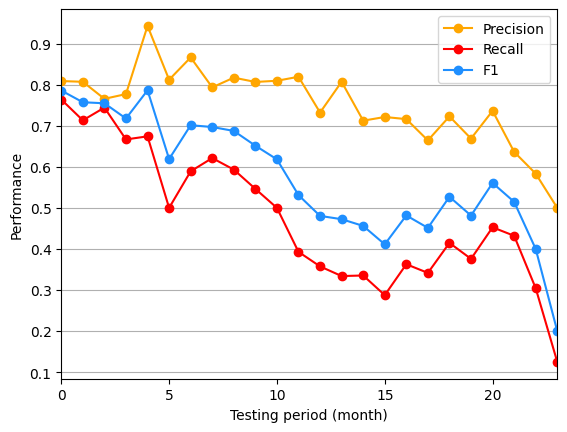

In [9]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")
#%%
from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

'#FF9999', '#FFDD99', '#AAEEEE'
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
legend(['Precision', 'Recall', 'F1'])
xlim([0,23])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

In [10]:
results.keys()
results['fn']

[34,
 37,
 55,
 61,
 72,
 108,
 113,
 103,
 144,
 142,
 187,
 224,
 221,
 317,
 422,
 436,
 288,
 183,
 206,
 352,
 81,
 46,
 16,
 7]

### Reproducing Figure 6

In [11]:
# Finding the optimal malware ratio in training data
from tesseract import spatial 

X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [ ]:
tp_list = results['tp']
tn_list = results['tn']
fp_list = results['fp']
fn_list = results['fn']

# Sum the lists
total_tp = sum(tp_list)
total_tn = sum(tn_list)
total_fp = sum(fp_list)
total_fn = sum(fn_list)

# Calculate accuracy
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
print(f"Overall Accuracy: {accuracy}")


Overall Accuracy: 0.9331138523087181


In [35]:
spatial_clf = LinearSVC()
optimal_malware_training_ratio, aut, error_rate = spatial.find_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=4, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    acceptable_errors=0.1,
    end_tr_rate=0.5 # Stop at max 50% malware
)
print(f"Optimal malware training ratio: {optimal_malware_training_ratio}")

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:05,  5.20s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:03,  3.93s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:02,  2.72s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-

Optimal malware training ratio: 0.5000000000000001


In [36]:
spatial_clf = LinearSVC()
rates = spatial.search_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=4, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    end_tr_rate=0.5 # Stop at max 50% malware
)

0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:05,  5.23s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:03,  3.53s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
1it [00:02,  2.58s/it]
0it [00:00, ?it/s]/home/laura/.pyenv/versions/3.10.15/envs/tesseract2/lib/python3.10/site-packages/scikit_learn-1.5.2-

In [40]:
import pandas as pd 

rates = pd.DataFrame(rates)
rates

,errors,auts,phis,fn,fp,total
0,0.030188,0.0,0.10,278.0,152.0,14244.0
1,0.032435,0.0,0.15,248.0,214.0,14244.0
2,0.031662,0.0,0.20,241.0,210.0,14244.0
3,0.032716,0.0,0.25,213.0,253.0,14244.0
4,0.037630,0.0,0.30,219.0,317.0,14244.0
5,0.035734,0.0,0.35,215.0,294.0,14244.0
6,0.039596,0.0,0.40,210.0,354.0,14244.0
7,0.039034,0.0,0.45,165.0,391.0,14244.0
8,0.042895,0.0,0.50,189.0,422.0,14244.0
